# Power Series Expansion Method to Estimate Nonlinear ODE Parameters

When physicists talk about nonlinear dynamics, they usually already have a model in mind which they can integrate numerically and do all sorts of analyses such as <a href="https://en.wikipedia.org/wiki/Phase_portrait" target="_blank">phase portraits</a> and <a href="https://en.wikipedia.org/wiki/Bifurcation_diagram" target="_blank">bifurcation diagrams</a>. This is fine and dandy if you already know, or at the very least have a good guess of the set of ordinary differential equations (ODEs) that describe the system, such as the following set of equations which describe the generation of <a href="https://www.researchgate.net/publication/253741071_Volcanic_termor_Nonlinear_excitation_by_fluid_flow" target="_blank">harmonic tremor in a volcanic system</a>.

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/Julian_tremor_model_eq.png?raw=True" alt="drawing" width="333"/>

However, what happens if you happen to have a <a href="https://academic.oup.com/gji/article-abstract/216/3/1768/5238725?redirectedFrom=fulltext" target="_blank">time series measurement with no ODEs to integrate</a>? Unfortunately in such a case we have to work solely with the time series data. In this post we will explore how to use <a href="https://en.wikipedia.org/wiki/Power_series" target="_blank">power series</a> expansion to invert a measured time series for its ODE power series coefficients. This will allow us to recreate to some extent the set of ODEs which govern the measured time series. 

Dynamical systems can be written in the general vector form _ẋ_ = _f_(_x_(_t_)). We assume that _f_(_x_(_t_)) can be expanded as a power series of order _n_. For example, a one dimensional dynamical system can be expanded in the form _ẋ_ = _c_<sub>0</sub> + _c_<sub>1</sub>_x_ + _c_<sub>2</sub>_x_<sup>2</sup> + _c_<sub>3</sub>_x_<sup>3</sup> + ..., while a two dimensional system can be expanded as _ẋ_ = _c_<sub>0</sub> + _c_<sub>1</sub>_x_ + _c_<sub>2</sub>_y_ + _c_<sub>3</sub>_x_<sup>2</sup> + _c_<sub>4</sub>_y_<sup>2</sup> + _c_<sub>5</sub>_xy_ + ... and _ẏ_ = _d_<sub>0</sub> + _d_<sub>1</sub>_x_ + _d_<sub>2</sub>_y_ + _d_<sub>3</sub>_x_<sup>2</sup> + _d_<sub>4</sub>_y_<sup>2</sup> + _d_<sub>5</sub>_xy_ + ... Higher order systems can be expanded using even more cross terms between the different variables. 

Note that the power series expansion of the derivatives can be written as a linear system __d__ = __Gm__, where __d__ is a _D_ × _M_ matrix containing the numerical derivatives _ẋ_, _ẏ_, ... where _D_ is the number of rows of data and _M_ is the number of variables, __G__ is a _D_ × _N_ matrix containing the power series expansions _x_, _y_, ... where _N_ is the number of parameters in the model, and ___m__ is a _N_ × _M_ matrix containing the power series coefficients _c_<sub>i</sub>, _d_<sub>i</sub>, ... Therefore, if we measure __d__ and construct __G__,we should be able to linearly invert the system for __m__, which will give us the power series coefficients of the system! 

The method described above works only if we already have obtained the full set of time series for all the variables x, y ... If only one time series is measurable as is the case for many experiments or natural phenomena, then <a href="https://en.wikipedia.org/wiki/Takens%27s_theorem" target="_blank">attractor reconstruction</a> must be used to reconstruct the N-dimensional attractor for analysis. A set of python codes used to reconstruct N-dimensional attractors from a single time series can be found in my <a href="https://github.com/natsunoyuki/nonlinpy" target="_blank">GitHub repository</a>.

In this post I will assume that for some reason, we were able to obtain the time series for all the variables of the system. Therefore we will skip the attractor reconstruction phase, and go straight to the power series expansion estimation phase which is the focus of this post. First of all, we need to numerically differentiate our set of time series, which can be done using the `make_dx4` below which returns central derivatives with fourth order errors. This results in a more stable numerical derivative at the cost of a loss of 2 rows of data from the start and the end of the time series for a total of 4 rows.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def dx4(x, dt):
    """
    This function calculates 1st order central derivative 
    with 4th order errors, hence the name dx4
    Inputs:
    x: array to be differentiated
    dt: time step size
    Outputs:
    dx: array of differentiated values of x
    """
    dx = np.zeros(len(x) - 4)
    for i in range(2, len(x) - 2):
        dx[i-2] = (-x[i+2]+8*x[i+1]-8*x[i-1]+x[i-2])/(dt*12)
    return dx

def make_dx4(X, dt):
    """
    This is the wrapper function to apply dx4() to a matrix
    instead of an array of nonlinear signals
    Input:
    X: matrix (multi-dimensional array) to be 
       differentiated. 
    dt: time step size
    Output:
    dX: matrix (multi-dimensional array) of differentiated X
    """
    n, m = np.shape(X)
    dX = np.zeros([n-4, m])
    for i in range(m):
        dX[:, i] = dx4(X[:, i], dt)
    return dX

After numerically differentiating the measured time series, we need to construct the inversion kernel __G__ with power series expansions of the measured time series. This can be done using the `make_G` function below. Note that `make_G` makes use of `sklearn`'s `PolynomialFeatures` function to build the power series expansion.

In [2]:
from sklearn.preprocessing import PolynomialFeatures

def make_G(X, degree):
    """
    Make inversion kernel G using the raw data matrix X.
    We tailor the length in order to account for the loss 
    of 2 rows at the start and end of the time series due 
    to the 1st order central differentiation dx4()
    Also, we use power series of polynomials of X to 
    construct the kernel G.
    Input:
    X: raw data matrix
    degree: polynomial degree to be constructed
    Output:
    G: inversion kernel matrix consisting of polynomials of X
    """
    G = X[2:-2]
    polyfeats = PolynomialFeatures(degree=degree,                
                                   interaction_only=False, 
                                   include_bias=True)
    G = polyfeats.fit_transform(G)
    return G  

Now that we have __d__ and __G__, we can now invert for __m__! The inversion is accomplished using the `least_squares function`. After inversion, we use the sparse representation algorithm proposed by <a href="https://www.pnas.org/content/113/15/3932" target="_blank">Brunton et al. PNAS 2016</a> to remove extremely small parameters and stabilise the inversion results. This is necessary as the raw inversion results tend to result in many "useless" parameters being filled with small values. It can be assumed that only a few parameters are important to the system, and the algorithm basically stabilises the result to those few large parameters. 

In [3]:
def least_squares(d, G):
    """
    Linear inversion using least squares to get the 
    Penrose pseudo inverse for over determined problems.
    Input:
    d: inversion data matrix
    G: inversion kernel matrix
    Output:
    m: inversion model matrix
    """    
    m = np.dot(np.linalg.inv(np.dot(G.T, G)), G.T)
    m = np.dot(m, d)
    return m

def sparse_representation(D, G, m, la = 0.1):
    """
    Sparse Representation Algorithm (Brunton et al. PNAS 2016) 
    to remove extremely small model parameters and stabilise
    the inversion results
    Input:
    D: inversion data matrix
    G: inversion kernel matrix   
    m: inversion model matrix
    la: threshold limit for expansion coefficient values. 
        0.1 by default
    Output:
    m: modified inversion model matrix
    """
    for k in range(10):
        smallinds = abs(m) < la
        m[smallinds] = 0
        for ind in range(np.shape(D)[1]):
            biginds = np.logical_not(smallinds[:, ind])
            M = least_squares(D[:, ind], G[:, biginds])
            m[biginds, ind] = M
    return m

def calculate_m(D, G):
    """
    Perform the linear inversion, as well as calculate 
    the sparse representation of m.
    Input:
    D: inversion data matrix
    G: inversion kernel matrix
    Output:
    m: inversion model matrix
    """
    m = least_squares(D, G)
    m = sparse_representation(D, G, m)   
    return m

We put everything together in `nonlinear_inversion`.

In [4]:
def nonlinear_inversion(X, dt, degree):
    """
    This is the main driver function to perform linear 
    inversion of nonlinear signals to obtain the ODE model.
    Inputs:
    X: the nonlinear signal to be analyzed.
    dt: time step size
    Outputs:
    D: inversion data matrix
    G: inversion kernel matrix
    m: inversion model matrix
    P: inversion predictions of D
    """
    # Perform the order differentiation
    D = make_dx4(X, dt)
    
    # Build the kernel for linear inversion
    G = make_G(X, degree)
    
    # Perform the linear inversion
    m = calculate_m(D, G)  
    
    # Make the predictions using the model
    P = np.dot(G, m)
    
    return D, G, m, P

For this demonstration we will use the time series solution of the <a href="https://en.wikipedia.org/wiki/Lorenz_system" target="_blank">Lorenz attractor</a> with `σ = 10`, `β = 8.0 / 3.0` and `ρ = 28`. The Lorenz attractor is generated by integrating `lorenz_attractor` numerically using `odeint` from `scipy.integrate`.

The set of ODEs governing the Lorenz system are given by:

_ẋ_ = σ(_y_ - _x_)

_ẏ_ = _x_(ρ - _z_) - _y_ 

_ż_ = _xy_ - β_z_

are coded in `lorenz_attractor` as shown below.

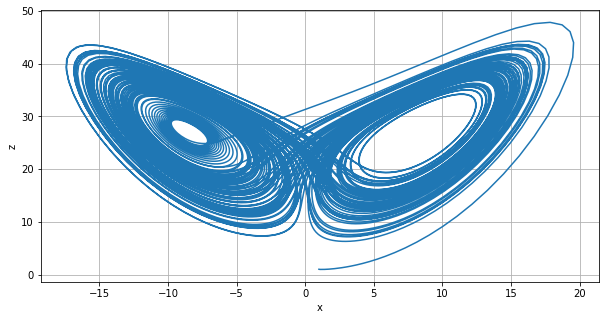

In [5]:
from scipy.integrate import odeint

def lorenz_attractor(x, t, params):
    xdot = np.zeros(len(x))
    xdot[0] = params[0] * (x[1] - x[0])  # x
    xdot[1] = x[0] * (params[2] - x[2]) - x[1]  # y
    xdot[2] = x[0] * x[1] - params[1] * x[2]  # z
    return xdot

dt = 0.01
y = odeint(lorenz_attractor, y0 = np.array([1, 1, 1]), t = np.arange(0, 100, dt), args = ([10, 8/3, 28],))

plt.figure(figsize = (10, 5))
plt.plot(y[:, 0], y[:, 2])
plt.grid(True)
plt.xlabel("x")
plt.ylabel("z")
plt.show()

Using this synthetic data, we invert the system as a power series expansion using the functions above.

In [6]:
D, G, m, P = nonlinear_inversion(y, dt, 3)

Printing out the inverted power series coefficients show that we have been able to correctly extract the coefficients `σ = 10`, `β = 8.0 / 3.0` and `ρ = 28`.

In [7]:
print(m)

[[ 0.          0.          0.        ]
 [-9.99986977 27.99769322  0.        ]
 [ 9.99986979 -0.99946365  0.        ]
 [ 0.          0.         -2.66660242]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.99997593]
 [ 0.         -0.9999394   0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


As an ending note, the inversion kernel __G__ can be constructed using other methods instead, such as Legendre polynomials etc. Care should be used when choosing the base functions to represent the measured time series.